In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import math

pd.options.display.max_columns = 100

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
# %config InlineBackend.figure_format = 'svg'

In [4]:
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score as f1

In [5]:
data = pd.read_csv('train.csv')

In [6]:
data.shape

(10000, 13)

In [7]:
data.head()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,choose
0,0,35.0,0.0,2150.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0,0
1,1,52.0,2.0,1250.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,57.0,1
2,2,29.0,3.0,1750.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,66.0,0
3,3,33.0,3.0,1050.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0,1
4,4,46.0,3.0,2250.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,73.0,0


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
Id                     10000 non-null int64
age                    10000 non-null float64
years_of_experience    10000 non-null float64
lesson_price           10000 non-null float64
qualification          10000 non-null float64
physics                10000 non-null float64
chemistry              10000 non-null float64
biology                10000 non-null float64
english                10000 non-null float64
geography              10000 non-null float64
history                10000 non-null float64
mean_exam_points       10000 non-null float64
choose                 10000 non-null int64
dtypes: float64(11), int64(2)
memory usage: 1015.7 KB


In [9]:
def hist(feat, print_vals=True):
    global dt
    dt = data[feat]
    if print_vals:
        display(dt.value_counts())
    dt.value_counts().sort_values().plot(kind='barh', grid=1, zorder=2);

In [10]:
def describe(feat):
    global dt
    dt = data[feat]
    display(dt.describe())
    print(f'max/med: {dt.max()/ dt.median()}')
    if dt.min() != 0:
        print(f'med/min: {dt.median()/ dt.min()}')

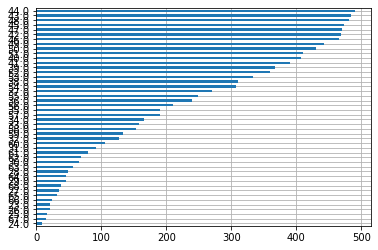

In [11]:
hist('age', False)

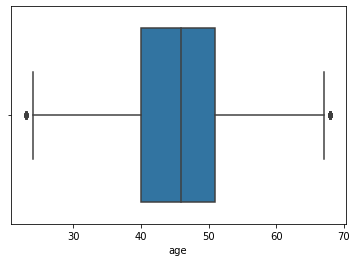

In [12]:
sns.boxplot(dt);

0.0    2774
1.0    1842
2.0    1743
3.0    1545
4.0    1177
5.0     581
6.0     234
7.0      73
8.0      22
9.0       9
Name: years_of_experience, dtype: int64

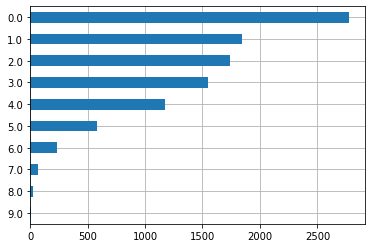

In [13]:
hist('years_of_experience')

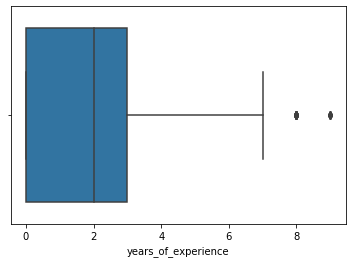

In [14]:
sns.boxplot(dt);

In [15]:
describe('lesson_price')

count    10000.000000
mean      1702.440000
std        523.789062
min        200.000000
25%       1300.000000
50%       1550.000000
75%       2150.000000
max       3950.000000
Name: lesson_price, dtype: float64

max/med: 2.5483870967741935
med/min: 7.75


1.0    4891
2.0    3033
3.0    2018
4.0      58
Name: qualification, dtype: int64

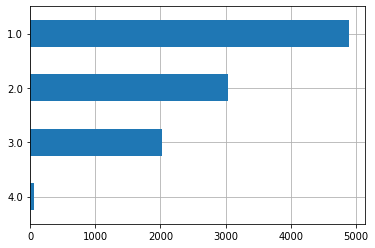

In [16]:
hist('qualification')

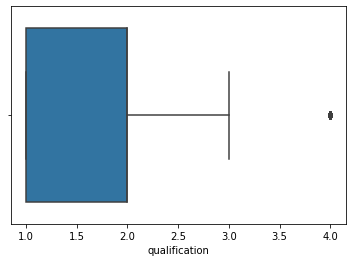

In [17]:
sns.boxplot(dt);

In [18]:
def balance_df_by_target(df, target_name):
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [19]:
def FeatMean(df, feat):
    return df[[feat, 'choose']].groupby([feat]).mean()

def _float_feat(src, dst, cat_feat):
    df = FeatMean(src, cat_feat)
    ret = dst.merge(df, left_on=cat_feat, right_on=cat_feat, how='left')
    if 'choose_x' in ret.columns:
        ret.rename(columns={'choose_x': 'choose', 'choose_y': cat_feat + ' Mean'}, inplace=True)
    else:
        ret.rename(columns={'choose': cat_feat + ' Mean'}, inplace=True)
    return ret

def float_feat(src, dst):
    src = _float_feat(src, src, 'age')
    src = _float_feat(src, src, 'years_of_experience')
    src = _float_feat(src, src, 'qualification')
    
    dst = _float_feat(src, dst, 'age')
    dst = _float_feat(src, dst, 'years_of_experience')
    dst = _float_feat(src, dst, 'qualification')
    
    src.drop(['age', 'years_of_experience', 'qualification'], axis=1, inplace=True)
    dst.drop(['age', 'years_of_experience', 'qualification'], axis=1, inplace=True)
    
    return src, dst

In [20]:
train, valid = train_test_split(data, test_size=0.3, random_state=42)

In [21]:
train, valid = float_feat(train, valid)

In [22]:
train.head()

,Id,lesson_price,physics,chemistry,biology,english,geography,history,mean_exam_points,choose,age Mean,years_of_experience Mean,qualification Mean
0,9069,1250.0,1.0,0.0,0.0,0.0,0.0,0.0,59.0,1,0.109195,0.117551,0.099208
1,2603,1450.0,0.0,0.0,0.0,0.0,0.0,0.0,41.0,0,0.154930,0.117551,0.099208
2,7738,1200.0,0.0,0.0,1.0,0.0,0.0,0.0,58.0,1,0.120000,0.102551,0.099208
3,1579,2250.0,0.0,0.0,0.0,0.0,0.0,0.0,78.0,0,0.115044,0.102551,0.131449
4,5058,2200.0,1.0,0.0,1.0,0.0,0.0,0.0,87.0,1,0.109195,0.102551,0.131449


In [23]:
train['choose'].value_counts()

0    6235
1     765
Name: choose, dtype: int64

In [24]:
train = balance_df_by_target(train, 'choose')

In [25]:
train['choose'].value_counts()

0    6235
1    6120
Name: choose, dtype: int64

In [26]:
feats = train.columns
feats = feats.drop(['Id', 'choose'])
feats

Index(['lesson_price', 'physics', 'chemistry', 'biology', 'english',
       'geography', 'history', 'mean_exam_points', 'age Mean',
       'years_of_experience Mean', 'qualification Mean'],
      dtype='object')

In [27]:
X_train = train.loc[:, feats].to_numpy()
X_valid = valid.loc[:, feats].to_numpy()
y_train = train['choose'].to_numpy()
y_valid = valid['choose'].to_numpy()

In [28]:
X_train_tr = X_train.transpose()
y_train_tr = y_train.reshape(1, y_train.shape[0])
X_valid_tr = X_valid.transpose()
y_valid_tr = y_valid.reshape(1, y_valid.shape[0])

In [29]:
def log_loss(w, X, y):
    m = X.shape[1]

    # используем функцию сигмоиды, написанную ранее
    A = sigmoid(np.dot(w.T, X))
    
    loss = -1.0 / m * np.sum(y * np.log(A) + (1 - y) * np.log(1 - A))
    loss = np.squeeze(loss)
    grad = 1.0 / m * np.dot(X, (A - y).T)
    
    return loss, grad

In [30]:
def optimize(w, X, y, n_iterations, eta):
#     потери будем записывать в список для отображения в виде графика
    losses = []
    
    for i in range(n_iterations):        
        loss, grad = log_loss(w, X, y)
        w = w - eta * grad

        losses.append(loss)
        
    return w, losses

In [31]:
def predict(w, X):
    
    m = X.shape[1]
    
    y_predicted = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    A = sigmoid(np.dot(w.T, X))
    
#     За порог отнесения к тому или иному классу примем вероятность 0.5
    for i in range(A.shape[1]):
        if (A[:,i] > 0.5): 
            y_predicted[:, i] = 1
        elif (A[:,i] <= 0.5):
            y_predicted[:, i] = 0
    
    return y_predicted

In [32]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [ ]:
%%time

# иницилизируем начальный вектор весов
w0 = np.zeros((X_train_tr.shape[0], 1))

n_iterations = 500000
eta = 0.05

w, losses = optimize(w0, X_train_tr, y_train_tr, n_iterations, eta)

y_predicted_valid = predict(w, X_valid_tr)
y_predicted_train = predict(w, X_train_tr)

# В качестве меры точности возьмем долю правильных ответов
train_accuracy = 100.0 - np.mean(np.abs(y_predicted_train - y_train_tr)*100.0)
valid_accuracy = 100.0 - np.mean(np.abs(y_predicted_valid - y_valid_tr)*100.0)

print(f"Итоговый вектор весов w: {w}")
print(f"Точность на обучающей выборке: {train_accuracy:.3f}")
print(f"Точность на валидационной выборке: {valid_accuracy:.3f}")

In [ ]:
pd.DataFrame(y_predicted_train).T[0].value_counts()

In [35]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [36]:
train, test = float_feat(train, test)

In [37]:
train['choose'].value_counts()

0    8891
1    1109
Name: choose, dtype: int64

In [38]:
train = balance_df_by_target(train, 'choose')

In [39]:
train['choose'].value_counts()

0    8891
1    8872
Name: choose, dtype: int64

In [40]:
X_train = train.loc[:, feats].to_numpy()
X_test = test.loc[:, feats].to_numpy()
y_train = train['choose'].to_numpy()

In [41]:
X_train_tr = X_train.transpose()
y_train_tr = y_train.reshape(1, y_train.shape[0])
X_test_tr = X_test.transpose()

In [42]:
%%time

# иницилизируем начальный вектор весов
w0 = np.zeros((X_train_tr.shape[0], 1))

w, losses = optimize(w0, X_train_tr, y_train_tr, n_iterations, eta)

y_predicted_test = predict(w, X_test_tr)
y_predicted_train = predict(w, X_train_tr)

# В качестве меры точности возьмем долю правильных ответов
train_accuracy = 100.0 - np.mean(np.abs(y_predicted_train - y_train_tr)*100.0)

print(f"Итоговый вектор весов w: {w}")
print(f"Точность на обучающей выборке: {train_accuracy:.3f}")

Итоговый вектор весов w: [[ -78.86066635]
 [1015.0871463 ]
 [ 442.54383297]
 [ 319.33142468]
 [  70.31731771]
 [  18.19228298]
 [ -30.15951085]
 [1504.17837994]
 [ -18.85517453]
 [ -40.64765751]
 [  -5.96502211]]
Точность на обучающей выборке: 61.245
Wall time: 25min 30s


In [43]:
result = pd.DataFrame(y_predicted_test).T
result[0].value_counts()

0.0    9167
1.0     833
Name: 0, dtype: int64

In [44]:
result.index.name = 'Id'
result.columns = ['choose']

In [45]:
result.index += 10000

In [46]:
result.head()

,choose
Id,
10000,0.0
10001,0.0
10002,0.0
10003,0.0
10004,0.0


In [47]:
result.to_csv('./pred_test.csv', index=True, header=True)